In [1]:
import torch  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cuda


In [4]:
import pandas as pd  
import numpy as np  
import torch.nn as nn  
from sklearn.preprocessing import MinMaxScaler  
  
# Load and preprocess data  
df = pd.read_csv('resampled_cpu_usage_per_machine.csv')  
df['start_time'] = pd.to_datetime(df['start_time'])  
df.set_index('start_time', inplace=True)  
  
# Select one machine  
df = df[df['machine_id'] == df['machine_id'].values[1]]  
df = df[['maximum_cpu_usage']]  
  
# Scale data to (0, 1) for LSTM  
scaler = MinMaxScaler(feature_range=(0, 1))  
df['maximum_cpu_usage'] = scaler.fit_transform(df['maximum_cpu_usage'].values.reshape(-1,1))  
  
# Convert DataFrame to numpy array  
data = df['maximum_cpu_usage'].values  
  
# Split data into train and test sets  
train_size = int(len(data) * 0.80)  
train_data, test_data = data[:train_size], data[train_size:] 

class Attention(nn.Module):  
    def __init__(self, input_size, hidden_size):  
        super(Attention, self).__init__()  
        self.linear = nn.Linear(input_size, hidden_size)  
  
    def forward(self, x):  
        scores = self.linear(x)  
        scores = torch.tanh(scores)  
        attention_weights = torch.softmax(scores, dim=1)  
        context_vector = torch.sum(attention_weights * x, dim=1)  
        return context_vector.view(1, -1, self.linear.out_features)  
  
class LSTM(nn.Module):    
    def __init__(self, input_size, hidden_size, num_layers, output_size):    
        super(LSTM, self).__init__()    
        self.hidden_size = hidden_size    
        self.num_layers = num_layers  
  
        self.attention = Attention(input_size, hidden_size)  
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)    
        self.fc = nn.Linear(hidden_size, output_size)    
    
    def forward(self, x):    
        h_0 = self.attention(x).to(x.device)  
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)    
    
        out, _ = self.lstm(x, (h_0, c_0))    
        out = self.fc(out[:, -1, :])    
    
        return out    
  
  
# Set up LSTM model parameters
seq_length_in = 144
seq_length_out = 6
num_epochs = 10
learning_rate = 0.01  
input_size = 1  
hidden_size = 4
num_layers = 1
output_size = seq_length_out
  
lstm = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
  
# Set loss function and optimizer  
criterion = torch.nn.MSELoss()    # mean-squared error for regression  
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)  
  
# Create sequences  
def create_sequences(input_data, seq_length_in, seq_length_out):  
    inout_seq = []  
    L = len(input_data)  
    for i in range(L-seq_length_in-seq_length_out):  
        train_seq = input_data[i:i+seq_length_in]  
        train_label = input_data[i+seq_length_in:i+seq_length_in+seq_length_out]  
        inout_seq.append((train_seq ,train_label))  
    return inout_seq  
  
train_inout_seq = create_sequences(train_data, seq_length_in, seq_length_out)  
  
# Train model  
lstm.train()
for epoch in range(num_epochs):  
    for seq, labels in train_inout_seq:  
        # FloatTensor: This is a multi-dimensional matrix containing elements of a single data type, in this case, float. It's a specific type of tensor provided by PyTorch.
        # Tensor: This is a general term used for n-dimensional arrays in PyTorch. When you create a Tensor in PyTorch without specifying a type, it defaults to FloatTensor. So, torch.Tensor is essentially equivalent to torch.FloatTensor.
        # tensor: This is a function in PyTorch used to create a Tensor. It's similar to FloatTensor, but it infers the data type from the data. If you pass in floats, it will create a FloatTensor. If you pass in integers, it will create an IntTensor, etc.
        # The -1 in .view(-1, seq_length_out) is a placeholder that PyTorch will fill in with the appropriate number to maintain the same total number of elements in the tensor. For example, if you have a tensor of shape (4, 3) and you do .view(-1, 2), the resulting tensor will have shape (6, 2), as PyTorch fills in the -1 with a 6 to maintain the same total number of elements (12 in this case).
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)
        labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)
          
        optimizer.zero_grad()  
        y_pred = lstm(seq)  
          
        single_loss = criterion(y_pred, labels)  
        single_loss.backward()  
        optimizer.step()  
  
    # if epoch%25 == 0:  
    # Compute and print RMSE for training  
    train_rmse = np.sqrt(single_loss.item())  
    print('epoch: ', epoch, 'train RMSE: ', train_rmse, 'loss: ', single_loss.item())  
  
# Test model
lstm.eval()
test_inout_seq = create_sequences(test_data, seq_length_in, seq_length_out)
predictions = []  
with torch.no_grad():  
    for seq, labels in test_inout_seq:  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
        y_test_pred = lstm(seq)  
          
        # Ensure labels and y_test_pred have the same size  
        if y_test_pred.shape != labels.shape:  
            print("Shape mismatch: y_test_pred has shape {} but labels have shape {}".format(y_test_pred.shape, labels.shape))  
            continue  
  
        test_loss = criterion(y_test_pred, labels)    
        test_rmse = np.sqrt(test_loss.item())    
        # print('Test RMSE: ', test_rmse) 
       


epoch:  0 train RMSE:  0.1291407561719797 loss:  0.016677334904670715
epoch:  1 train RMSE:  0.1306496476802426 loss:  0.01706933043897152
epoch:  2 train RMSE:  0.12996945323740078 loss:  0.01689205877482891
epoch:  3 train RMSE:  0.12861633934376698 loss:  0.016542162746191025
epoch:  4 train RMSE:  0.12746869814432843 loss:  0.016248269006609917
epoch:  5 train RMSE:  0.12655597334386964 loss:  0.016016414389014244
epoch:  6 train RMSE:  0.1258404388129472 loss:  0.01583581604063511
epoch:  7 train RMSE:  0.125279821180292 loss:  0.015695033594965935
epoch:  8 train RMSE:  0.12483835945141031 loss:  0.015584615990519524
epoch:  9 train RMSE:  0.12448986834115537 loss:  0.015497727319598198


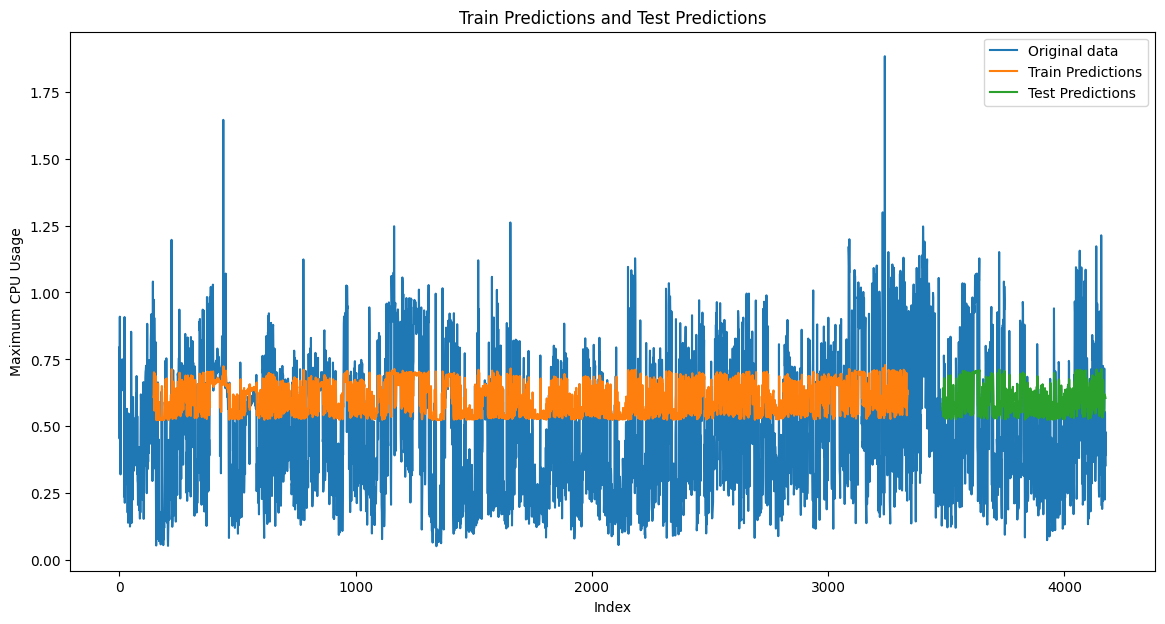

In [5]:
import matplotlib.pyplot as plt  

# Create empty arrays of NaNs  
train_predictions = np.empty_like(data)  
train_predictions[:] = np.nan  
test_predictions = np.empty_like(data)  
test_predictions[:] = np.nan  
  
# Generate predictions  
lstm.eval()  
with torch.no_grad():  
    for i, (seq, labels) in enumerate(train_inout_seq):  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        train_pred = lstm(seq)  
        train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()  
  
    for i, (seq, labels) in enumerate(test_inout_seq):  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        test_pred = lstm(seq)  
        test_predictions[i+train_size+seq_length_in : i+train_size+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()  

train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))  
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))  
data = scaler.inverse_transform(data.reshape(-1, 1))  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(len(data)), data, label='Original data')  
  
# Train predictions  
plt.plot(range(len(data)), train_predictions, label='Train Predictions')  
  
# Test predictions  
plt.plot(range(len(data)), test_predictions, label='Test Predictions')  
  
plt.title('Train Predictions and Test Predictions')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  


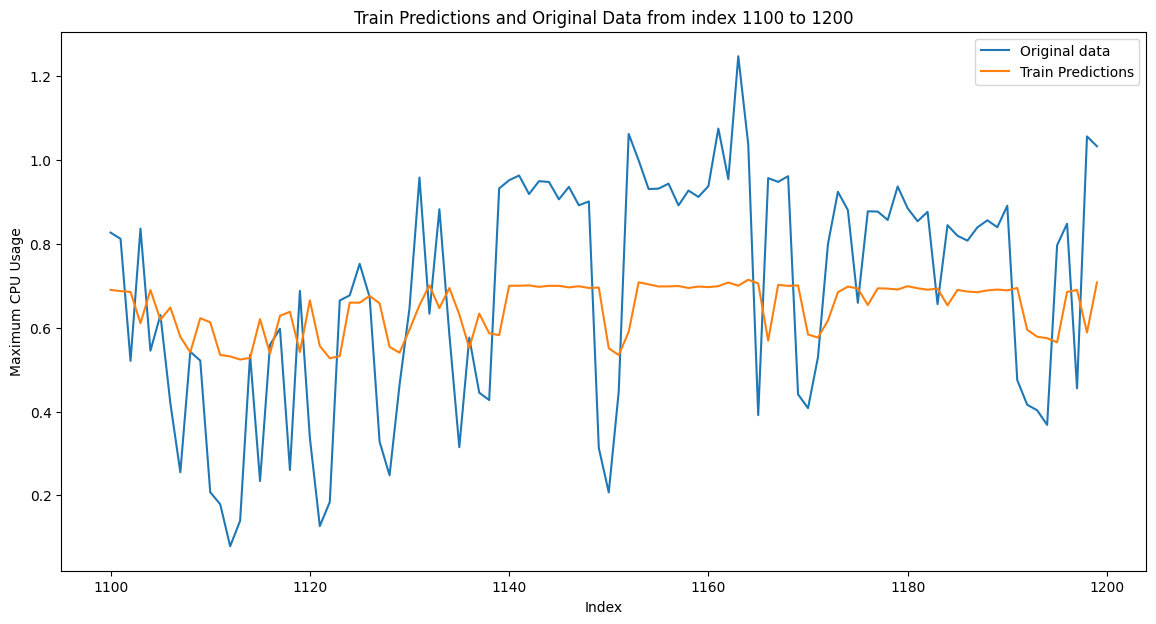

In [6]:
# Define the range of interest  
start_index = 1100  
end_index = 1200  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')  
  
# Train predictions  
plt.plot(range(start_index, end_index), train_predictions[start_index:end_index], label='Train Predictions')  
  
plt.title('Train Predictions and Original Data from index 1100 to 1200')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  


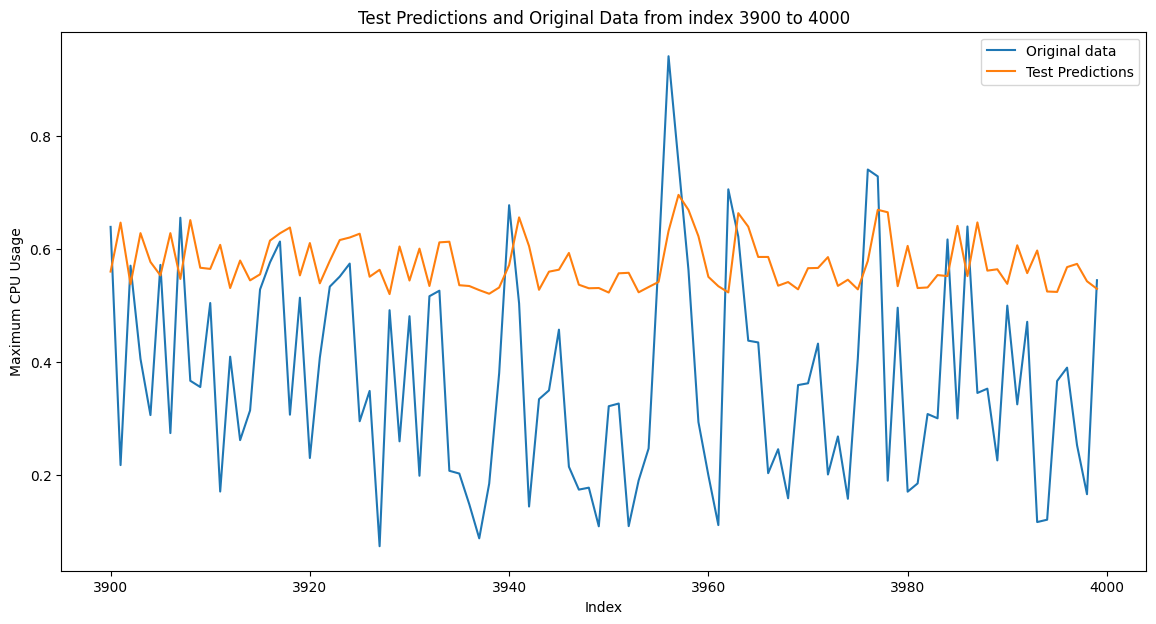

In [8]:
# Define the range of interest  
start_index = 3900  
end_index = 4000  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')  
  
# Test predictions  
plt.plot(range(start_index, end_index), test_predictions[start_index:end_index], label='Test Predictions')  
  
plt.title('Test Predictions and Original Data from index 3900 to 4000')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  
